In [7]:
import sys
sys.path.append('/home/enes/bim/')# you should have this package on the sys.path

from utils import InferEta, Neutrality_Tests, Colless, intersect_with_weights
from Bimbalance import bSFS, bTree, PConst,Pnkb

In [8]:
import tskit
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from time import time
import seaborn as sns

plt.style.use('default')

In [9]:
ts = tskit.load('example.trees')
ts

In [70]:
import jax.numpy as jnp
from jax import lax
import jax
from jax.scipy.special import gammaln as LG
jax.config.update("jax_enable_x64", True)

from gmpy2 import mpq
import gmpy2
gmpy2.get_context().precision = 1000

from functools import partial, lru_cache
from dataclasses import dataclass
import scipy
import tskit
import re
import numpy as np

from utils import tree_to_splits

@lru_cache(None)
def _nc2(N):
    return N * (N - 1) // 2

@lru_cache(None)
def _A(N):
    '''
    returns A_jk calculated as eq6 @ Polanski

    Parameters
    ----------
    N : int
        sample size.

    Returns
    -------
    A : ndarray

    '''
    A = np.zeros([N - 1, N - 1], dtype=object)
    for k in range(2, N + 1):
        for j in range(k, N + 1):
            A[k - 2, j - 2] = np.prod([mpq(_nc2(ell), _nc2(ell) - _nc2(j)) for ell in range(k, N + 1) if ell != j])
    A[N - 2, N - 2] = 1
    return A

def get_BETmm(eta, N):
    j = np.arange(2, N + 1)
    k = np.arange(2, N + 1)
    A = _A(N)
    B = (A * (j * (j - 1))[None, :] / (k - 1)[:, None])
    ETmm = [eta.exp_integral(j * (j - 1) // 2) for j in range(2, N + 1)]
    BETmm = B @ ETmm        
    return BETmm.astype('float')
    
# def fr(n, k, beta):
#     '''
#     reflected beta-binomial
#     log of the fr in the paper    
    
#     Parameters
#     ----------
#     n : ndarray or int
#         number of sample the node subtends to.
#     k : ndarray or int (same size with n)
#         number of sample the right (or left) child subtends to.
#     beta : float (0, \infnty)
#         beta-splitting parameter.

#     Returns
#     -------
#     ndarray or float (same size with n)

#     '''
#     l = n//2+1
#     g = 1.
    
#     beta = jnp.exp(beta)
#     normalizer = 2*(1-BB(l,0,beta,g)-BB(l,l,beta,g))
#     normalizer = normalizer - (1-jnp.mod(n,2))*BB(l,l-1,beta,g)
#     return jnp.where(k>=l, BB(l,n-k,beta,g), BB(l,k,beta,g))/normalizer

# # def fr(n, k, beta):
# #     x = jnp.where(k == 1, 0.5, 0)
# #     x += jnp.where(k == n-1, 0.5, 0)
# #     return x

# @partial(jax.jit)
# def fr(n, k, beta):
#     beta = 2*(jnp.exp(beta)-1)
#     pmf = LG(k+beta+1) + LG(n-k+beta+1) - LG(k+1) - LG(n-k+1)
#     #hb = LG(2*beta+2) + LG(beta+n+1) - LG(2*beta+n+2) - LG(beta+1)
#     #nc = 1-2*jnp.exp(hb)
        
#     return jnp.exp(pmf)#/nc

# # def fr(n, k, beta):
# #     beta = jnp.exp(beta)
# #     pmf = LG(k+beta) + LG(n-k+beta) - LG(k+1) - LG(n-k+1)
# #     hb = LG(2*beta+2) + LG(beta+n+1) - LG(2*beta+n+2) - LG(beta+1)
# #     nc = 1-2*jnp.exp(hb)
# #     return jnp.exp(pmf)/nc

@partial(jax.jit)
def fs(n, k, beta):
    beta = jnp.exp(beta)
    T1 = LG(n+1) - LG(k+1) - LG(n-k+1)
    T2 = LG(k+beta) + LG(n-k+beta) - LG(n+beta+beta)
    T3 = LG(beta+beta) - LG(beta) - LG(beta)
    return jnp.exp(T1 + T2 + T3)

@partial(jax.jit)
def fa(n, k, beta):
    beta = 2*(jnp.exp(beta)-1)
    return jnp.exp(LG(k+beta+1) + LG(n-k+beta+1) - LG(k+1) - LG(n-k+1))

def Pnkb(N, beta, pmf):
   
    n = jnp.arange(1, N+1)[:, None]
    k = jnp.arange(1, N+1)[None, :]
    P = jnp.where(k < n, pmf(n, k, beta)+pmf(n, n-k, beta), 0)
    P = jax.ops.index_update(P, jax.ops.index[1:,:], 2*P[1:,:]/P[1:,:].sum(axis = 1)[:,None])
    P = P - jnp.identity(N)
    
    State = jnp.zeros(N)
    State = jax.ops.index_update(State, jax.ops.index[N-1], 1)
    lins = jnp.arange(N)
    State = State.reshape(1, N)
       
    mean_ling = jnp.concatenate([jnp.zeros(N - 1), jnp.ones(1)])
    def loop_body(mean_ling_im1, i):
        State = i * mean_ling_im1
        probs = lins * State # weight the probs with size (Durett forward split)
        probs /= jnp.sum(probs)
        State += jnp.matmul(probs, P)      
        State = jax.ops.index_update(State, jax.ops.index[-i], 0)
        return (State / (i + 1),) * 2

    _, mean_ling = lax.scan(loop_body, mean_ling, jnp.arange(1, N))
    
    return mean_ling[:,:-1]

In [133]:
beta

DeviceArray(-1.90042586, dtype=float64)

In [146]:
n = 300
k = jnp.arange(n+1)
beta = 0.5
beta = 2*(jnp.exp(beta)-1)

fx = LG(k+beta+1) + LG(n-k+beta+1) - LG(k+1) - LG(n-k+1)

a1 = np.log(-(2**(-2 - 2*beta))*(np.sqrt(np.pi))/(np.sin((beta+n)*np.pi)))

l1 = LG(-0.5-beta)
l2 = LG(1+beta)
l3 = LG(-1-2*beta-n)
l4 = LG(1+n)

norm = a1+l1+l2-l3-l4

In [147]:
jnp.exp(fx-norm).sum()

DeviceArray(1., dtype=float64)

In [145]:
beta

DeviceArray(0., dtype=float64)

In [60]:
# a1 = np.log(-(2**(-2 - 2*beta))*(np.sqrt(np.pi))/(np.sin((beta+n)*np.pi)))

# l1 = LG(-0.5-beta)
# l2 = LG(1+beta)
# l3 = LG(-1-2*beta-n)
# l4 = LG(1+n)

# a1+l1+l2-l3-l4

In [61]:
eta = PConst(a = [1.], t = [0.])
N = 100
BETmm = get_BETmm(eta, N)

def Ebl(beta, pmf):
    pnkb = Pnkb(N, beta, pmf)
    model = jnp.matmul(pnkb.T, BETmm)
    return model

In [63]:
nt = Neutrality_Tests(N)

In [64]:
betas = np.linspace(-10, 10, 31)

In [65]:
beta = -10
n = 10
x = np.arange(1, n)
fx = np.abs(n-2*x)
p = fs(n, x, beta)
p.sum()

DeviceArray(0.00012842, dtype=float64)

In [66]:
def Efs(n, beta, f):
    x = np.arange(1, n)
    fx = f(x)
    p = fs(n, x, beta)
    return (fx*p).sum()
Efs(10, -10., lambda x: np.abs(10-2*x))

DeviceArray(0.00069803, dtype=float64)

In [67]:
def EIc(n, beta, pmf):
    
    def Ef(i):
        x = np.arange(1, i)
        fx = np.abs(n-2*x)
        p = pmf(n, x, beta)
        p /= p.sum()
        return (fx*p).sum()   
    
    pnkb = Pnkb(n, beta, pmf)
    t = Ef(n)
    
    for k in range(2, n-1):
        i = np.arange(2, n-k+3)
        t += np.sum(((i-1)/(n-k))*pnkb[k-2, i-2]*np.array([Ef(_) for _ in i]))

    return t/((n-1)*(n-2)/2)

fs

In [19]:
dfcorr = []

for beta in betas:   
    sfs = Ebl(beta, fs)
    
    cur = {'bsfs': beta,
           'TajD': nt.TajD(sfs, False), 'FulD': nt.FulD(sfs, False), 'FayH': nt.FayH(sfs, False),
           'ZngE': nt.ZngE(sfs, False)}
    dfcorr.append(cur)

dfcorr = pd.DataFrame(dfcorr)

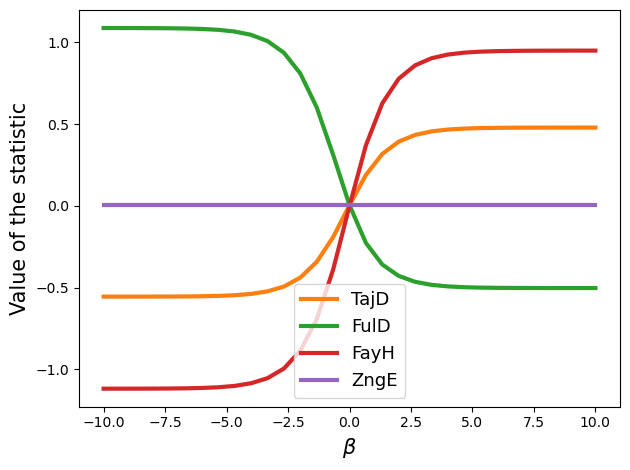

In [20]:
plt.style.use('default')
plt.plot(0, 0)
for stat in dfcorr.columns[1:]:
    x = dfcorr['bsfs']
    plt.plot(x, dfcorr[stat], linewidth = 3, label = stat)
plt.legend(ncol = 1, prop={'size': 13})
plt.xlabel(r'$\beta$', size = 15)
plt.ylabel('Value of the statistic', size = 15)
plt.tight_layout()
plt.savefig('plots/betasfs_rls.jpg', dpi = 300)

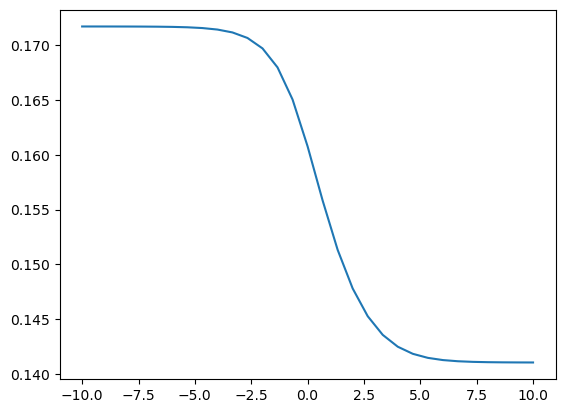

In [22]:
EIcs = []
for beta in betas:
    EIcs.append(EIc(N, beta, fs))
    
plt.plot(betas, EIcs)

fA

In [76]:
betas = np.linspace(-8, 4, 101)

dfcorr = []

for beta in betas:   
    sfs = Ebl(beta, fa)
    
    cur = {'bsfs': beta,
           'TajD': nt.TajD(sfs, False), 'FulD': nt.FulD(sfs, False), 'FayH': nt.FayH(sfs, False),
           'ZngE': nt.ZngE(sfs, False)}
    dfcorr.append(cur)

dfcorr = pd.DataFrame(dfcorr)

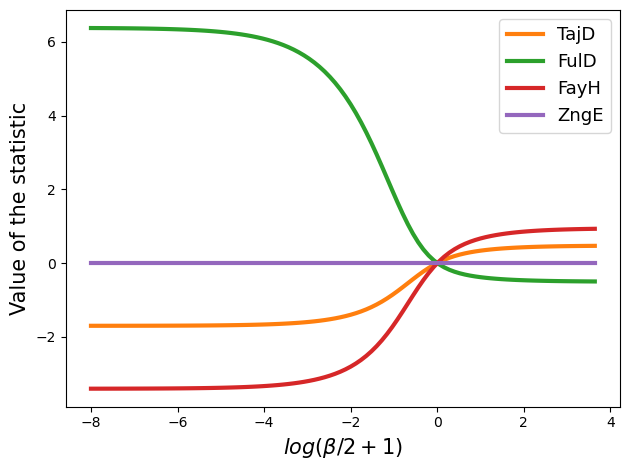

In [77]:
plt.style.use('default')
plt.plot(0, 0)
for stat in dfcorr.columns[1:]:
    x = dfcorr['bsfs']
    plt.plot(x, dfcorr[stat], linewidth = 3, label = stat)
plt.legend(ncol = 1, prop={'size': 13})
plt.xlabel(r'$log(\beta/2+1)$', size = 15)
plt.ylabel('Value of the statistic', size = 15)
plt.tight_layout()
plt.savefig('plots/betasfs_rls.jpg', dpi = 300)

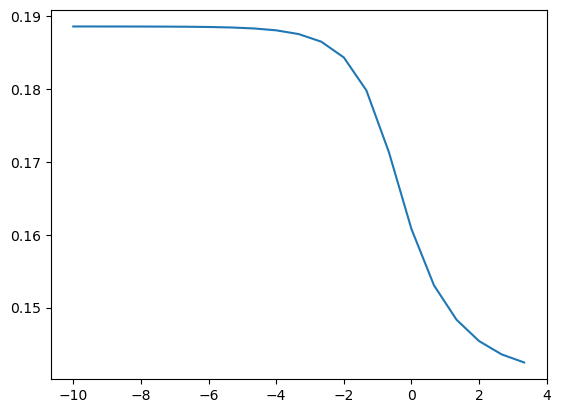

In [25]:
EIcs = []
for beta in betas:
    EIcs.append(EIc(N, beta, fa))
    
plt.plot(betas, EIcs)

Taj D

In [78]:
betas = np.linspace(-8, 4, 13)

tajcor = []

for N in [50, 100, 150, 200, 250, 300]:
    BETmm = get_BETmm(eta, N)

    def Ebl(beta, pmf):
        pnkb = Pnkb(N, beta, pmf)
        model = jnp.matmul(pnkb.T, BETmm)
        return model
    
    nt = Neutrality_Tests(N)
    for beta in betas:   
        sfs = Ebl(beta, fa)

        cur = {'N': N,
               'bsfs': beta,
               'TajD': nt.TajD(sfs, False)}
        tajcor.append(cur)

tajcor = pd.DataFrame(tajcor)

In [79]:
tajcor['TajD'] = tajcor['TajD'].astype('float')

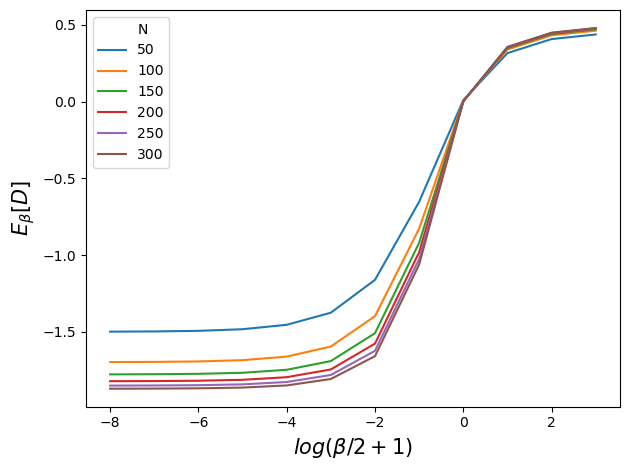

In [83]:
sns.lineplot('bsfs', 'TajD', hue = 'N', data = tajcor, palette=sns.color_palette('tab10', n_colors=6))
plt.xlabel(r'$log(\beta/2+1)$', size = 15)
plt.ylabel(r'$E_{\beta}[D]$', size = 15)
plt.tight_layout()
plt.savefig('plots/betasfs_tajd.jpg', dpi = 300)

In [41]:
@partial(jax.jit)
def fs(n, k, beta):
    beta = jnp.exp(beta)
    T1 = LG(n+1) - LG(k+1) - LG(n-k+1)
    T2 = LG(k+beta) + LG(n-k+beta) - LG(n+beta+beta)
    T3 = LG(beta+beta) - LG(beta) - LG(beta)
    return jnp.exp(T1 + T2 + T3)

@partial(jax.jit)
def fa(n, k, beta):
    return jnp.exp(LG(k+beta+1) + LG(n-k+beta+1) - LG(k+1) - LG(n-k+1))

In [42]:
n = 100
k = 20
beta = -2.
np.exp(LG(k+beta+1) + LG(n-k+beta+1))

7.250228005161573e+130

In [38]:
beta = 2.
beta = 2*(jnp.exp(beta)-1)
beta

DeviceArray(12.7781122, dtype=float64)

In [270]:
def EIc(n, beta, Ef):
    pnkb = Pnkb(n, beta)
    t = Ef(n, beta, lambda x: np.abs(n-2*x))
    
    for k in range(2, n-1):
        i = np.arange(2, n-k+3)
        t += np.sum(((i-1)/(n-k))*pnkb[k-2, i-2]*np.array([Ef(_, beta, lambda x: np.abs(_-2*x)) for _ in i]))

    return t/((n-1)*(n-2)/2)

In [271]:
betas = np.linspace(-10, 10, 51)

EIcs = []
for beta in betas:
    EIcs.append(EIc(n, beta))
    
plt.plot(betas, EIcs)

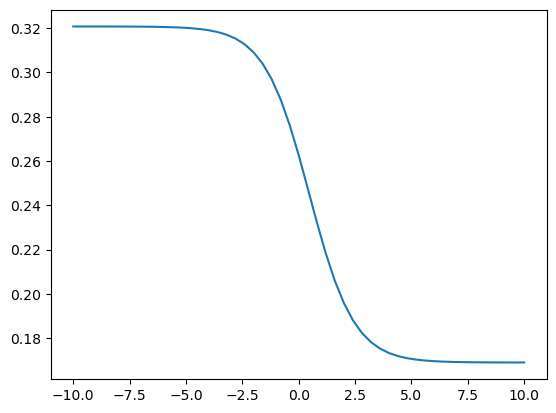

In [272]:
plt.plot(betas, EIcs

In [ ]:
2+2